In [1]:
import numpy as np
import matplotlib.pyplot as plt
%pylab inline
pylab.rcParams.update({'font.size': 12})
pylab.rcParams.update({'font.family': 'sans serif'})
pylab.rcParams.update({'mathtext.default':'regular'})
pylab.rcParams.update({'mathtext.fontset':'stixsans'})
pylab.rcParams.update({'axes.linewidth': 1.5})
pylab.rcParams.update({'xtick.direction':'in'})
pylab.rcParams.update({'xtick.major.size': 5})
pylab.rcParams.update({'xtick.major.width': 1.25 })
pylab.rcParams.update({'xtick.minor.size': 2.5})
pylab.rcParams.update({'xtick.minor.width': 1.25 })
pylab.rcParams.update({'ytick.direction':'in'})
pylab.rcParams.update({'ytick.major.size': 5})
pylab.rcParams.update({'ytick.major.width': 1.25 })
pylab.rcParams.update({'ytick.minor.size': 2.5})
pylab.rcParams.update({'ytick.minor.width': 1.25 })

import warnings
warnings.filterwarnings("ignore")

Populating the interactive namespace from numpy and matplotlib


In [32]:
class DustIntegrator:
    # conversion factors to get CGS units into Cholla units
    MP = 1.6726E-24;  # proton mass in grams
    KB = 1.380658e-16; # Boltzmann constant
    LENGTH_UNIT = 3.08567758e21; # kpc in cm
    TINY_NUMBER = 1.0e-20;
    MASS_UNIT = 1.98855e33; # solar mass in grams
    TIME_UNIT = 3.15569e10; # kyr in s
    DENSITY_UNIT = (MASS_UNIT/(LENGTH_UNIT*LENGTH_UNIT*LENGTH_UNIT)); 
    VELOCITY_UNIT = (LENGTH_UNIT/TIME_UNIT);
    PRESSURE_UNIT = (DENSITY_UNIT*VELOCITY_UNIT*VELOCITY_UNIT);
    
    # solar abundances (percentage of total mass)
    # O, C, N, Si, Mg, Ne, Fe, S
    metals = np.array([0.0097, 0.0040, 0.00096, 0.00099, 0.00076, 0.00058, 0.0014, 0.00040]);
    metallicity = np.sum(metals)
    
    def __init__(self, T, n, dt, t_max):
        self.T = T
        self.n = n
        self.dt = dt
        self.t_max = t_max
        self._d0_gas, self._d0_metal, self._d0_dust = self.calc_init_density()
        self.d_gas, self.d_metal, self.d_dust = self.calc_init_density()
        self.tau_g = self.calc_tau_g()
        self.tau_sp = self.calc_tau_sp()
        self.type = "tot_dust_density"

    def calc_tau_g(self):
        tau_g_ref = 0.2e9 # 0.2 Gyr
        d_ref = self.MP * self.LENGTH_UNIT ** 3 / self.MASS_UNIT # 1 H atom per cubic centimer
        T_ref = 20.0;
        tau_g = tau_g_ref * (d_ref/(self._d0_gas)) * (T_ref/self.T) ** (1/2);
        
        return tau_g
    
    def calc_tau_sp(self):
        a1 = 3;
        d0 = 1;
        T_0 = 2e6;
        omega = 2.5;
        A = 1.7e8; # units: yr
        
        tau_sp = A * (a1/d0) * ((T_0/self.T) ** omega + 1);
        
        return tau_sp
    
    def calc_init_density(self):
        d0_gas = self.MP * self.n * self.LENGTH_UNIT ** 3 / self.MASS_UNIT
        d0_metal = self.metallicity * d0_gas
        # assume 1% dust to gas fraction
        d0_dust = d0_gas / 100
        
        return d0_gas, d0_metal, d0_dust

    def calc_dd_dt(self):
        # calculate the rate of change of dust density
        # accretion term + sputtering term
        dd_dt = (1 - self.d_dust/self.d_metal)*(self.d_dust/self.tau_g) - self.d_dust/(self.tau_sp/3)
        
        return dd_dt
    
    def calc_d_dust(self):
        # calculate the new total dust density
        dd_dt = self.calc_dd_dt()
        d_dust_i = self.d_dust + self.dt * dd_dt
        
        return d_dust_i
    
    def update_densities(self):
        # update the integrator's density attributes
        dd_dt = self.calc_dd_dt()
        self.d_dust += self.dt * dd_dt
        self.d_metal -= self.dt * dd_dt
    
    def get_info(self):
        print("Gas temperature: {:.1E} K".format(self.T))
        print("Gas initial density: {:.5E} M_sun/kpc^3".format(self._d0_gas))
        print("Growth timescale: {:.5E} yr".format(self.tau_g))
        print("Destruction timescale: {:.5E} kyr".format(self.tau_sp))
        print("Time-step: {} yr".format(self.dt))
        print("------------------------------------------")

In [33]:
def evolve_solutions(h, n, T_arr, t_max):
    YEAR_IN_SECONDS = 3.154e7
    h /= YEAR_IN_SECONDS
    t_max /= YEAR_IN_SECONDS
    
    t_arr = np.arange(0, t_max, h)
    
    d_dust = np.zeros(shape=(len(T_arr), len(t_arr)))
    d_metal = np.zeros(shape=(len(T_arr), len(t_arr)))

    integrators = []
    
    taus = []
    
    def time_refine(integrator):
        """Refine time-step if dd is changing too rapidly."""
        d_dust_i = integrator.calc_d_dust()
        dd_dt = integrator.calc_dd_dt()
        dt = integrator.dt
        dd = dd_dt * dt
        while dd/d_dust_i > 0.01:
            dt_sub = 0.01 * d_dust_i / dd_dt

            integrator.d_dust += dt_sub * dd_dt
            integrator.d_metal -= dt_sub * dd_dt
            integrator.dt -= dt_sub
            dt = integrator.dt
            dd_dt = integrator.calc_dd_dt()
            dd = dt * dd_dt

    for j, T in enumerate(T_arr):
        integrator = DustIntegrator(T, n, h, t_max)
        integrator.get_info()
        # set initial densities
        d_dust[j][0] = integrator._d0_dust
        taus.append(integrator.tau_g) # yrs
        integrators.append(integrator)

        for i, t_i in enumerate(t_arr):
            if (i+1) < len(t_arr):
                for integrator in integrators:
                    # calculate dust density for this time-step
                    d_dust_i = integrator.calc_d_dust()
                    # calculate dd
                    dd_dt = integrator.calc_dd_dt()
                    dd = integrator.dt * dd_dt

                    # if rate of dust growth is changing too rapidly
                    if dd/d_dust_i > 0.01:
                        # shorten time-step
                        time_refine(integrator)
                        integrator.dt = h
                        d_dust[j][i+1] = integrator.d_dust
                        d_metal[j][i+1] = integrator.d_metal
                        continue

                    # this is where the density gets updated
                    integrator.update_densities()
                    d_dust[j][i+1] = integrator.d_dust
                    d_metal[j][i+1] = integrator.d_metal

    return d_dust, d_metal, taus, integrators

In [34]:
dd, dm, tau_gs, acc_integrator = evolve_solutions(1e3, 1e-2, [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8], 1e9)

Gas temperature: 1.0E+01 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.82843E+10 yr
Destruction timescale: 9.12316E+21 kyr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 8.94427E+09 yr
Destruction timescale: 2.88500E+19 kyr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.82843E+09 yr
Destruction timescale: 9.12316E+16 kyr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 8.94427E+08 yr
Destruction timescale: 2.88500E+14 kyr
Time-step: 1000.0 yr
------------------------------------------
Gas temperature: 1.0E+05 K
Gas initial density: 2.47120E+05 M_sun/kpc^3
Growth timescale: 2.82843E+08 yr
Destruction timescale: 9.12826E+11 kyr
Time-step: 1000.0 yr
---

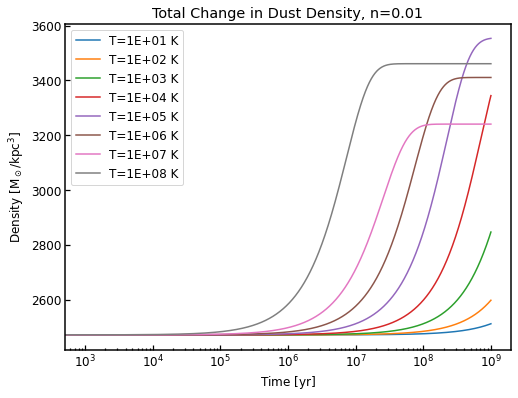

In [35]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for i, dd_i in enumerate(dd):
    ax.semilogx(np.arange(0, acc_integrator[i].t_max, acc_integrator[i].dt), dd_i, label=f"T={acc_integrator[i].T:.0E} K")
    #ax.vlines(tau_gs[i], ymin=np.amin(dd_i), ymax=np.amax(dd_i), color="k", linestyle="--", zorder=0)
    ax.set_xlabel("Time$~[yr]$")
    ax.set_ylabel(r"Density$~[M_\odot/kpc^3]$")
    ax.set_title(f"Total Change in Dust Density, n={acc_integrator[i].n}")
    ax.legend()

In [21]:
dd, dm, tau_gs, acc_integrator = evolve_solutions(10, 1e-1, [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8], 1e7)

Gas temperature: 1.0E+01 K
Gas initial density: 2.47120E+06 M_sun/kpc^3
Growth timescale: 2.79981E+06 kyr
Destruction timescale: 9.12316E+18 kyr
Time-step: 10 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial density: 2.47120E+06 M_sun/kpc^3
Growth timescale: 8.85378E+05 kyr
Destruction timescale: 2.88500E+16 kyr
Time-step: 10 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial density: 2.47120E+06 M_sun/kpc^3
Growth timescale: 2.79981E+05 kyr
Destruction timescale: 9.12316E+13 kyr
Time-step: 10 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial density: 2.47120E+06 M_sun/kpc^3
Growth timescale: 8.85378E+04 kyr
Destruction timescale: 2.88500E+11 kyr
Time-step: 10 yr
------------------------------------------
Gas temperature: 1.0E+05 K
Gas initial density: 2.47120E+06 M_sun/kpc^3
Growth timescale: 2.79981E+04 kyr
Destruction timescale: 9.12826E+08 kyr
Time-step: 10 yr
------------------

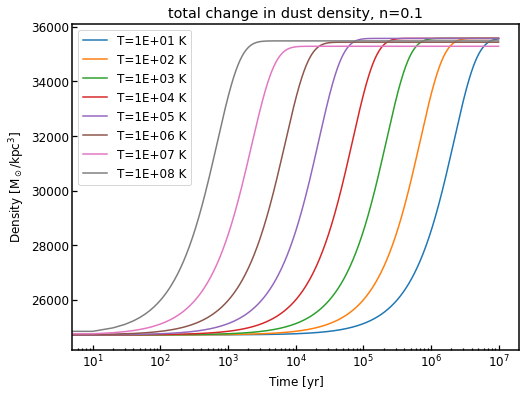

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for i, dd_i in enumerate(dd):
    ax.semilogx(np.arange(0, acc_integrator[i].t_max, acc_integrator[i].dt), dd_i, label=f"T={acc_integrator[i].T:.0E} K")
    #ax.vlines(tau_gs[i], ymin=np.amin(dd_i), ymax=np.amax(dd_i), color="k", linestyle="--", zorder=0)
    ax.set_xlabel("Time$~[yr]$")
    ax.set_ylabel(r"Density$~[M_\odot/kpc^3]$")
    ax.set_title(f"total change in dust density, n={acc_integrator[i].n}")
    ax.legend()

In [24]:
dd, dm, tau_gs, acc_integrator = evolve_solutions(10, 1, [1e1, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7, 1e8], 1e7)

Gas temperature: 1.0E+01 K
Gas initial density: 2.47120E+07 M_sun/kpc^3
Growth timescale: 2.79981E+05 kyr
Destruction timescale: 9.12316E+18 kyr
Time-step: 10 yr
------------------------------------------
Gas temperature: 1.0E+02 K
Gas initial density: 2.47120E+07 M_sun/kpc^3
Growth timescale: 8.85378E+04 kyr
Destruction timescale: 2.88500E+16 kyr
Time-step: 10 yr
------------------------------------------
Gas temperature: 1.0E+03 K
Gas initial density: 2.47120E+07 M_sun/kpc^3
Growth timescale: 2.79981E+04 kyr
Destruction timescale: 9.12316E+13 kyr
Time-step: 10 yr
------------------------------------------
Gas temperature: 1.0E+04 K
Gas initial density: 2.47120E+07 M_sun/kpc^3
Growth timescale: 8.85378E+03 kyr
Destruction timescale: 2.88500E+11 kyr
Time-step: 10 yr
------------------------------------------
Gas temperature: 1.0E+05 K
Gas initial density: 2.47120E+07 M_sun/kpc^3
Growth timescale: 2.79981E+03 kyr
Destruction timescale: 9.12826E+08 kyr
Time-step: 10 yr
------------------

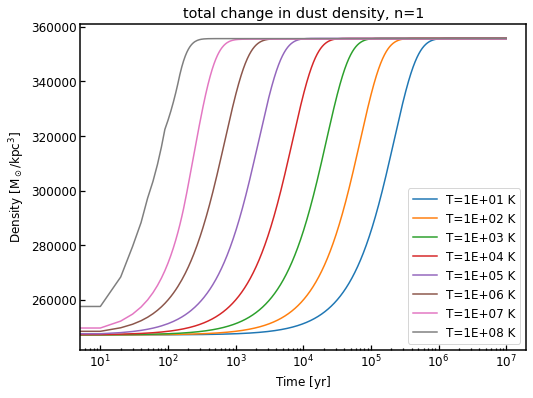

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=1, sharex=True, figsize=(8,6))
for i, dd_i in enumerate(dd):
    ax.semilogx(np.arange(0, acc_integrator[i].t_max, acc_integrator[i].dt), dd_i, label=f"T={acc_integrator[i].T:.0E} K")
    #ax.vlines(tau_gs[i], ymin=np.amin(dd_i), ymax=np.amax(dd_i), color="k", linestyle="--", zorder=0)
    ax.set_xlabel("Time$~[yr]$")
    ax.set_ylabel(r"Density$~[M_\odot/kpc^3]$")
    ax.set_title(f"total change in dust density, n={acc_integrator[i].n}")
    ax.legend()